In [85]:
import seaborn as sn
import quandl
API_KEY = "yCev-u-joPYss-FULGkt"
quandl.ApiConfig.api_key = (API_KEY)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [231]:
from sklearn.metrics import  mean_squared_error
import math
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [235]:
def forecast_accuracy(forecast, actual):
    mse = mean_squared_error(actual, forecast)
    return math.sqrt(mse)

Acotec-b

In [238]:
acotec_df = quandl.get('HKEX/06669')
acotec_df.head()

,Nominal Price,Net Change,Change (%),Bid,Ask,P/E(x),High,Low,Previous Close,Share Volume (000),Turnover (000),Lot Size
Date,,,,,,,,,,,,
2021-08-24,17.60,None,None,17.24,17.60,None,18.38,17.00,NaN,31056.0,552859.0,None
2021-08-25,18.86,None,None,18.86,18.88,None,19.14,17.20,17.60,8915.0,163877.0,None
2021-08-26,18.60,None,None,18.40,18.60,None,19.36,18.14,18.86,5249.0,97757.0,None
2021-08-27,18.10,None,None,18.10,18.20,None,18.70,18.10,18.60,1761.0,32177.0,None
2021-08-30,17.66,None,None,17.66,17.68,None,17.88,17.26,18.10,1820.0,32013.0,None


Let's try to predict the Nominal Price with time series

In [186]:
df = pd.DataFrame({'Date': acotec_df.index.values,
                          'value': acotec_df['Nominal Price']
                          })
df = df.reset_index(drop=True)
print(df.info())
# df.plot()
df.head()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    401 non-null    datetime64[ns]
 1   value   401 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 KB
None


,Date,value
0,2021-08-24,17.60
1,2021-08-25,18.86
2,2021-08-26,18.60
3,2021-08-27,18.10
4,2021-08-30,17.66


ADF Test for Null Hypothesis

In [187]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.879595
p-value: 0.341720


p-value > 0.05 => Null hypothesis is not true.
Now, to find 'd'

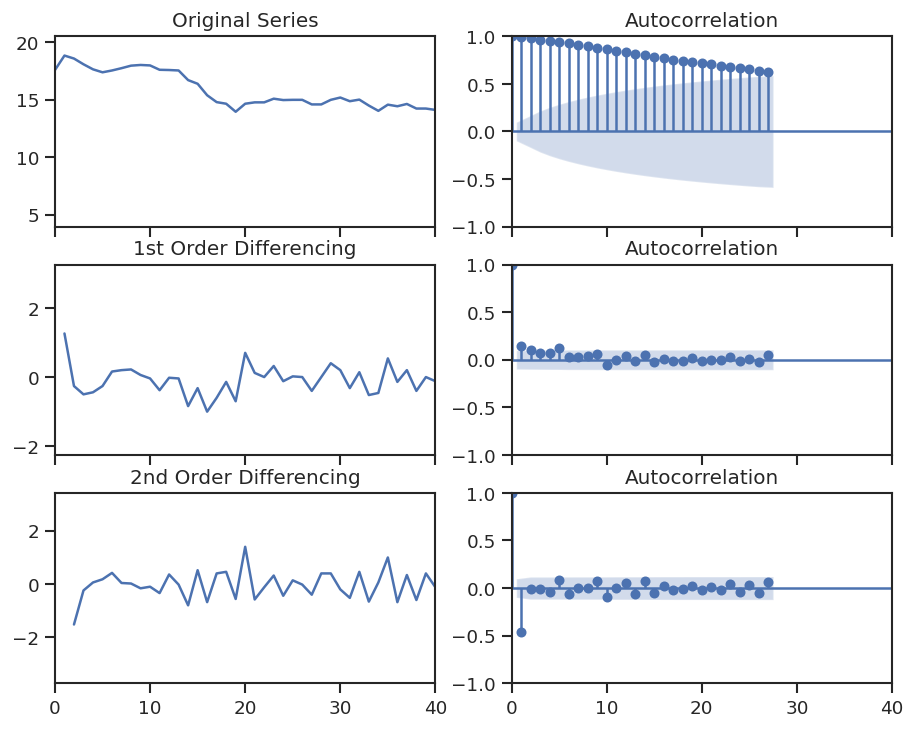

In [188]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
axes[0, 1].set_xlim([0, 40])
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 1].set_xlim([0, 40])
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

d=1, as the dataset becomes stationary at 2nd order differencing

Now, to find AR(p)

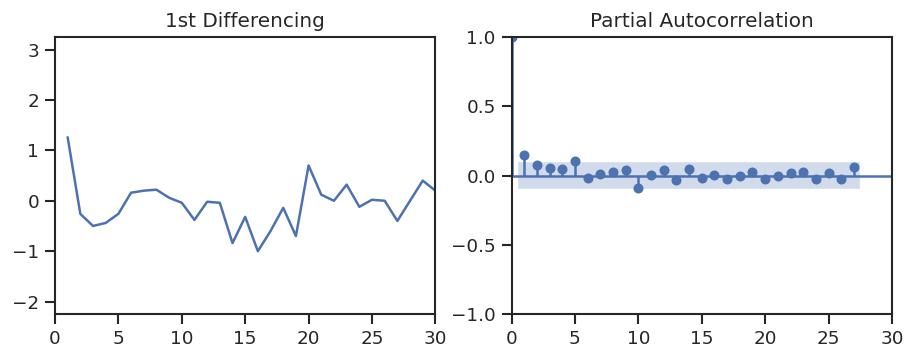

In [197]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,4))
axes[1].set_xlim([0, 30])
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

p = 1

Now, to find MA(q)

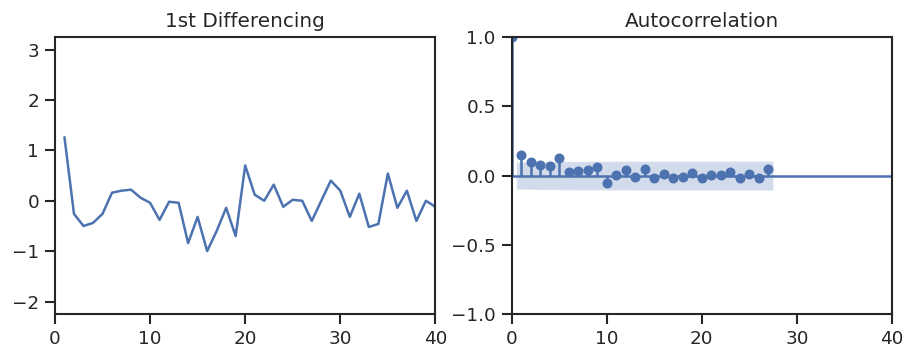

In [198]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set_xlim([0, 40])
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

q=1

Now, to create the model

In [220]:
from statsmodels.tsa.arima.model import ARIMA
train = df[:350]
test = df[350:]
# 1,1,1 ARIMA Model
model = ARIMA(train.value, order=(1,1,1))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  350
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -175.338
Date:                Wed, 19 Apr 2023   AIC                            356.676
Time:                        00:13:22   BIC                            368.241
Sample:                             0   HQIC                           361.280
                                - 350                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7945      0.122      6.505      0.000       0.555       1.034
ma.L1         -0.6767      0.152     -4.460      0.000      -0.974      -0.379
sigma2         0.1599      0.006     27.499      0.0

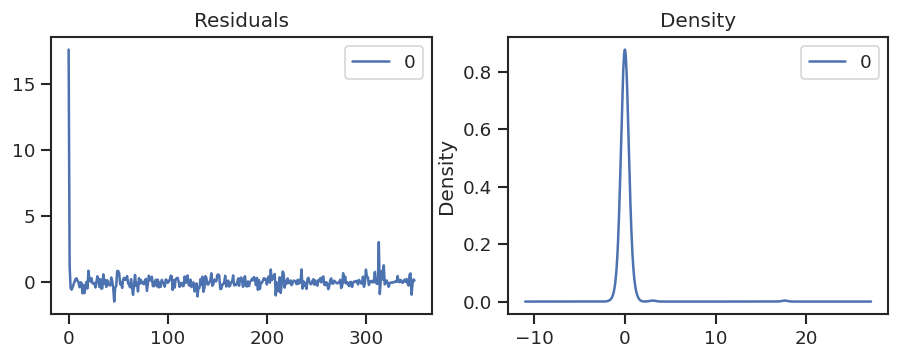

In [218]:
# Plot residual errors
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

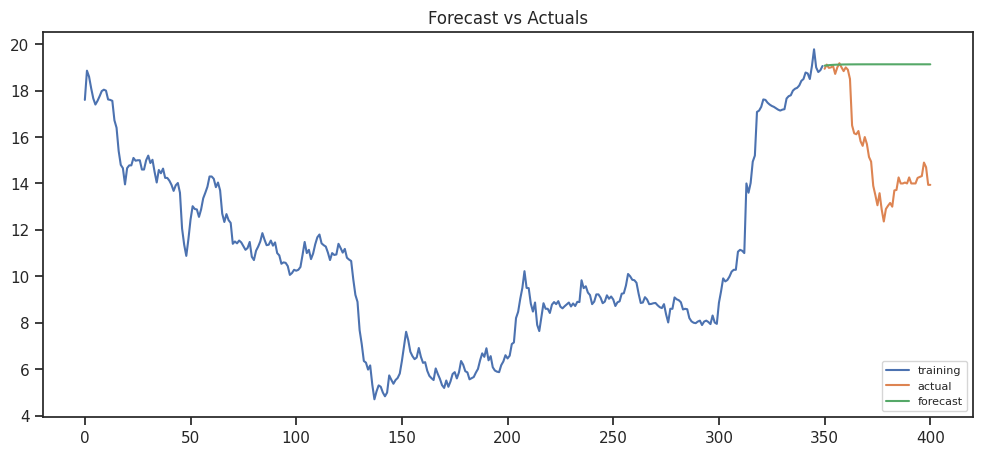

In [221]:
#Forecast
forecast = fitted.predict(start=350, end=400)
# print(forecast)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.value, label='training')
plt.plot(test.value, label='actual')
plt.plot(forecast, label='forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='lower right', fontsize=8)
plt.show()

Root Mean Squared Error (MSE)

In [236]:
print(forecast_accuracy(forecast,test.value))

4.26113755294209


(405,)


<Axes: xlabel='Date'>

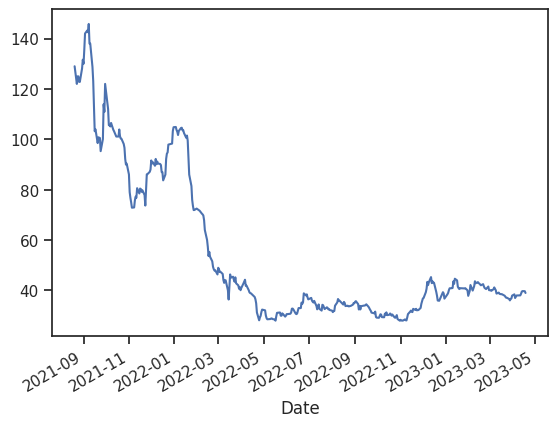

In [127]:
galaxy_df = quandl.get('HKEX/06609')['Nominal Price']
print(galaxy_df.shape)
galaxy_df.plot()

L- Auto-w

(413,)


<Axes: xlabel='Date'>

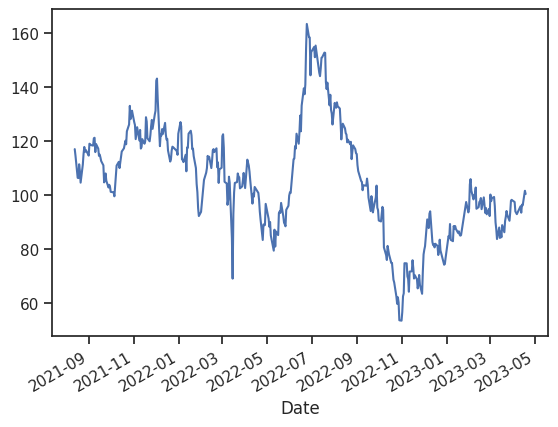

In [128]:
liAuto_df = quandl.get('HKEX/02015')['Nominal Price']
print(liAuto_df.shape)
liAuto_df.plot()

Mini-Hang Seng Index Futures

(166, 10)


<Axes: xlabel='Date'>

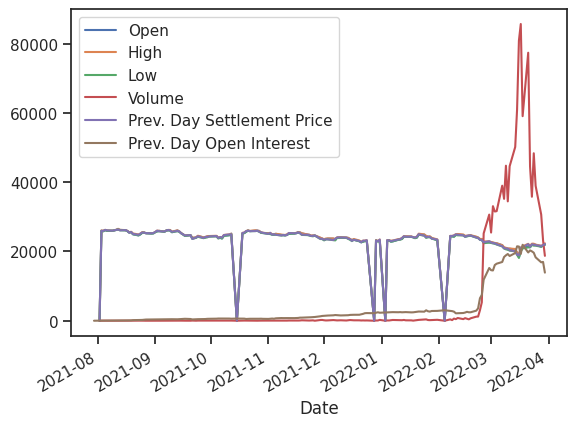

In [133]:
miniHangSeng_df = quandl.get('HKEX/MHINH2022')
print(miniHangSeng_df.shape)
miniHangSeng_df.plot()

In [129]:
hira_df = quandl.get('BSE/BOM512415')
# hira_df = hira_df.sort_index()
print(hira_df.shape)
hira_df['date'] = hira_df.index.values
hira_df = hira_df.reset_index(drop=True)
hira_df

(166, 10)


,Open,Bid,Ask,Last Traded,High,Low,Volume,Prev. Day Settlement Price,Net Change,Prev. Day Open Interest,date
0,NaN,None,None,None,NaN,NaN,NaN,NaN,None,1.0,2021-07-30
1,0.0,None,None,None,0.0,0.0,0.0,0.0,None,1.0,2021-08-02
2,26000.0,None,None,None,26069.0,25950.0,16.0,25986.0,None,29.0,2021-08-03
3,25925.0,None,None,None,25988.0,25790.0,11.0,25907.0,None,37.0,2021-08-04
4,26152.0,None,None,None,26251.0,26152.0,5.0,26250.0,None,66.0,2021-08-05
...,...,...,...,...,...,...,...,...,...,...,...
161,22075.0,None,None,None,22242.0,21688.0,48372.0,21975.0,None,19641.0,2022-03-24
162,21940.0,None,None,None,21982.0,21682.0,38978.0,21812.0,None,18314.0,2022-03-25
163,21380.0,None,None,None,21663.0,21380.0,30684.0,21619.0,None,16876.0,2022-03-28
164,21762.0,None,None,None,21895.0,21640.0,23270.0,21824.0,None,16990.0,2022-03-29


In [109]:
univariate_df = hira_df[['date','Close']].copy()
univariate_df.columns = ['ds','y']
train_size = int(0.85 * len(hira_df))

In [110]:
train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])


In [111]:
model = pm.auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=65.013, Time=0.74 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=64.990, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=63.054, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 1.309 seconds


In [112]:
model = ARIMA(y_train, order=(2,0,0),trend='c')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   17
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -28.907
Date:                Tue, 18 Apr 2023   AIC                             65.814
Time:                        21:17:38   BIC                             69.147
Sample:                             0   HQIC                            66.146
                                 - 17                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0366      1.684      2.990      0.003       1.736       8.338
ar.L1          1.0618      0.328      3.238      0.001       0.419       1.705
ar.L2         -0.3270      0.472     -0.693      0.4

In [115]:
y_pred = model_fit.forecast(3)

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 1.1165680324595335


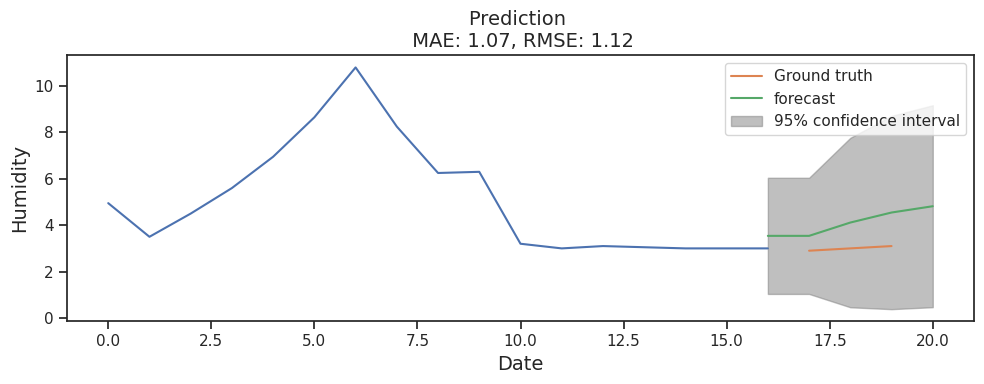

In [118]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, label='Ground truth') 
plot_predict(model_fit,16, 20, ax=ax)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Humidity', fontsize=14)

plt.tight_layout()